In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pandas_datareader import data

np.random.seed(42)

### Define function to download data

def download_stock_price_data(tickers, start_date, end_date):    
    # download the time series of adj. close price 
    # for each of the tickers from Yahoo finance
    # and dataframe with price changes
    
    df_prices = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)['Close']
    prev = df_prices.to_numpy()
    prev = prev / np.insert(prev[:-1,:], 0, np.ones(prev.shape[1]), 0)
    prev[0] = np.ones(prev.shape[1])
    df_price_changes = df_prices.copy(deep=True)
    df_price_changes[:] = prev

    return df_prices, df_price_changes

In [2]:
###========== Valuation with 2 years Volatility ============

[*********************100%***********************]  1 of 1 completed


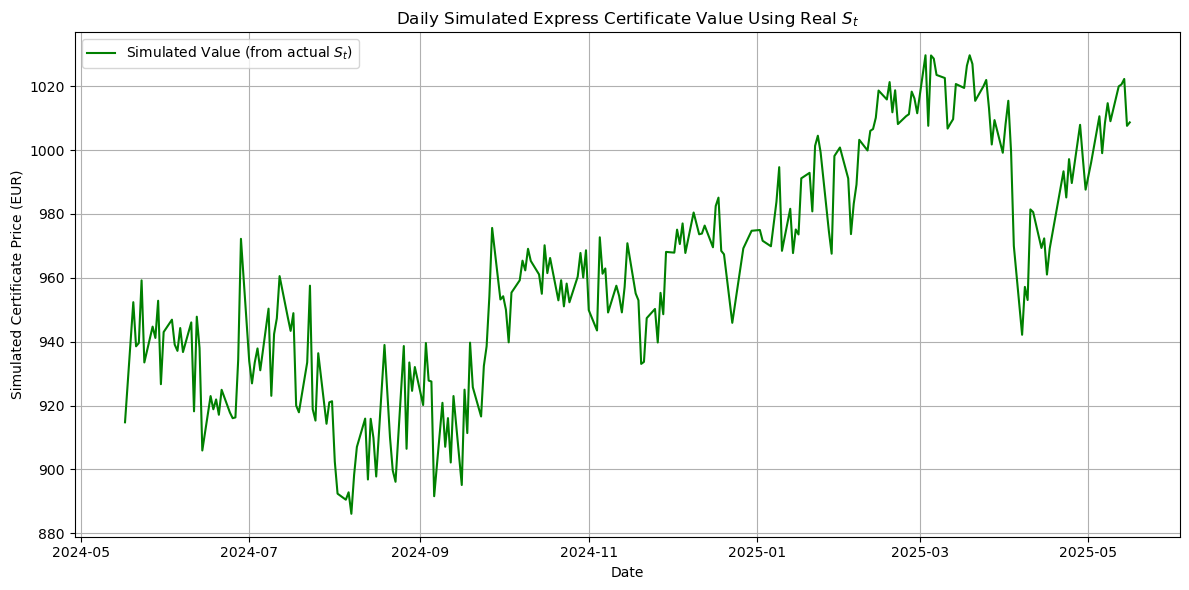

In [3]:
df_prices, _ = download_stock_price_data(['SIE.DE'], '2024-05-17', '2025-05-17')

# Prepare stock dataframe
df_stock = df_prices.rename(columns={"SIE.DE": "Close"}).reset_index()
df_stock["Date"] = pd.to_datetime(df_stock["Date"])
df_stock = df_stock.sort_values("Date").reset_index(drop=True)

# --- Parameters ---
S0=187.98
r = 0.022752  # use 6-year spot rate as a decimal
sigma = 0.27772
T_total = 6
N_total = 252 * T_total
dt = T_total / N_total
n_paths = 1000

nominal = 1000
coupon = 70
total_coupon = 6 * coupon
early_redemption_levels = [1.00, 0.95, 0.90, 0.85, 0.80]
observation_days = [252 * i for i in range(1, 6)]
barrier = 0.6 * S0  # fixed based on S0

# --- Simulate each day using actual S_t ---
simulated_prices = []

for idx, row in df_stock.iterrows():
    S_t = float(row["Close"])  # actual stock price on that day
    remaining_days = N_total - idx
    remaining_T = remaining_days / 252

    # Simulate paths
    Z = np.random.standard_normal((n_paths, remaining_days))
    paths = np.zeros_like(Z)
    paths[:, 0] = S_t

    for t in range(1, remaining_days):
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])

    # Compute payoffs
    payoffs = []
    for i in range(n_paths):
        path = paths[i]
        redeemed = False
        for j, obs_day in enumerate(observation_days):
            if obs_day < len(path) and path[obs_day] >= early_redemption_levels[j] * S0:
                payoffs.append(np.exp(-r * (obs_day / 252)) * (nominal + (j + 1) * coupon))
                redeemed = True
                break
        if not redeemed:
            S_end = path[-1]
            if S_end >= barrier:
                val = nominal + total_coupon
            else:
                val = nominal * (S_end / S0)
            payoffs.append(np.exp(-r * remaining_T) * val)

    simulated_prices.append(np.mean(payoffs))

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(df_stock["Date"], simulated_prices, label="Simulated Value (from actual $S_t$)", color="green")
plt.title("Daily Simulated Express Certificate Value Using Real $S_t$")
plt.xlabel("Date")
plt.ylabel("Simulated Certificate Price (EUR)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
###========== Valuation with 1 year Volatility ============

[*********************100%***********************]  1 of 1 completed


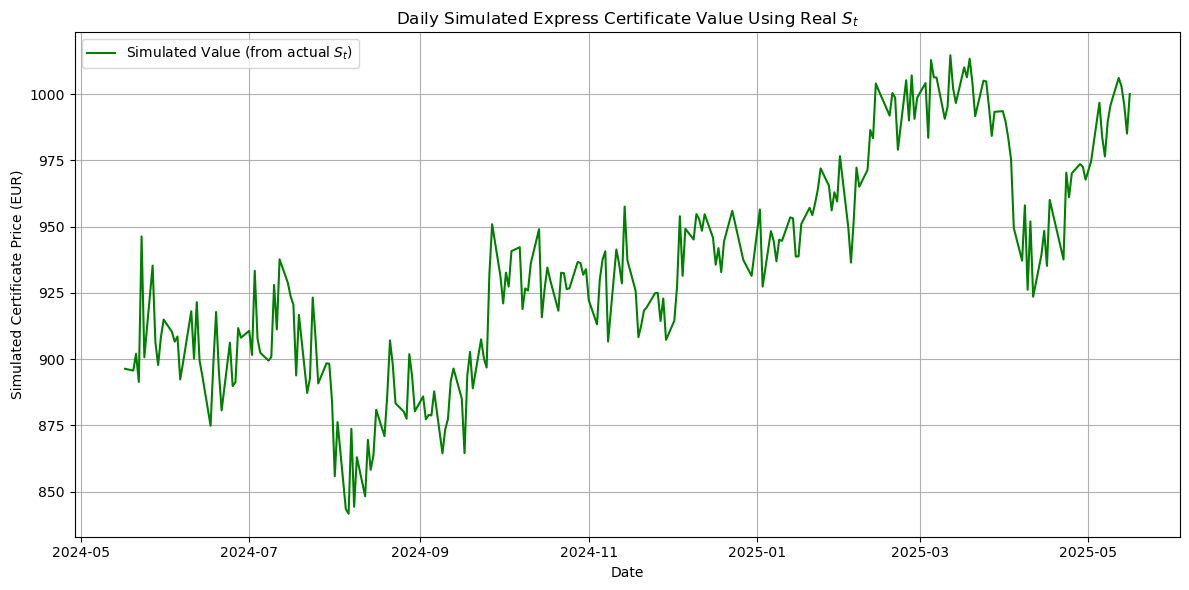

In [5]:

df_prices, _ = download_stock_price_data(['SIE.DE'], '2024-05-17', '2025-05-17')

# Prepare stock dataframe
df_stock = df_prices.rename(columns={"SIE.DE": "Close"}).reset_index()
df_stock["Date"] = pd.to_datetime(df_stock["Date"])
df_stock = df_stock.sort_values("Date").reset_index(drop=True)

# --- Parameters ---
S0=187.98
r = 0.022752  # use 6-year risk-free rate 
sigma = 0.31630
T_total = 6
N_total = 252 * T_total
dt = T_total / N_total
n_paths = 1000

nominal = 1000
coupon = 70
total_coupon = 6 * coupon
early_redemption_levels = [1.00, 0.95, 0.90, 0.85, 0.80]
observation_days = [252 * i for i in range(1, 6)]
barrier = 0.6 * S0  # fixed based on S0

# --- Simulate each day using actual S_t ---
simulated_prices_1y = []

for idx, row in df_stock.iterrows():
    S_t = float(row["Close"])  # actual stock price on that day
    remaining_days = N_total - idx
    remaining_T = remaining_days / 252

    # Simulate paths
    Z = np.random.standard_normal((n_paths, remaining_days))
    paths = np.zeros_like(Z)
    paths[:, 0] = S_t

    for t in range(1, remaining_days):
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])

    # Compute payoffs
    payoffs = []
    for i in range(n_paths):
        path = paths[i]
        redeemed = False
        for j, obs_day in enumerate(observation_days):
            if obs_day < len(path) and path[obs_day] >= early_redemption_levels[j] * S0:
                payoffs.append(np.exp(-r * (obs_day / 252)) * (nominal + (j + 1) * coupon))
                redeemed = True
                break
        if not redeemed:
            S_end = path[-1]
            if S_end >= barrier:
                val = nominal + total_coupon
            else:
                val = nominal * (S_end / S0)
            payoffs.append(np.exp(-r * remaining_T) * val)

    simulated_prices_1y.append(np.mean(payoffs))

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(df_stock["Date"], simulated_prices_1y, label="Simulated Value (from actual $S_t$)", color="green")
plt.title("Daily Simulated Express Certificate Value Using Real $S_t$")
plt.xlabel("Date")
plt.ylabel("Simulated Certificate Price (EUR)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

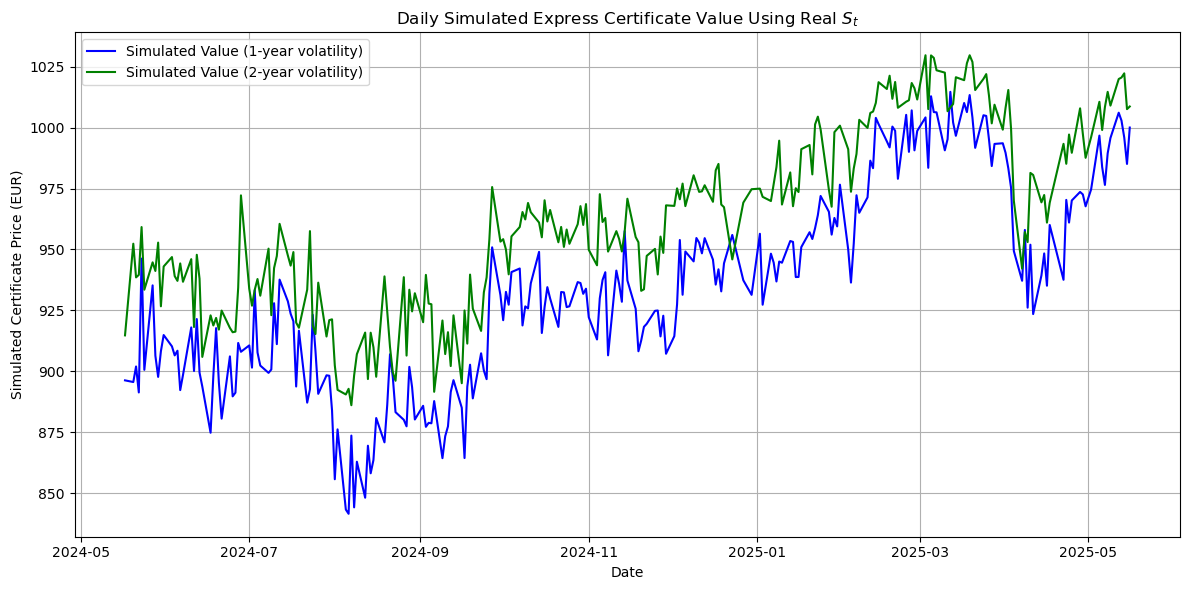

In [6]:
### ============== Plots =================

plt.figure(figsize=(12, 6))

# Plot 1-year volatility simulation
plt.plot(df_stock["Date"], simulated_prices_1y, label="Simulated Value (1-year volatility)", color="blue")

# Plot 2-year volatility simulation
plt.plot(df_stock["Date"], simulated_prices, label="Simulated Value (2-year volatility)", color="green")



plt.title("Daily Simulated Express Certificate Value Using Real $S_t$")
plt.xlabel("Date")
plt.ylabel("Simulated Certificate Price (EUR)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

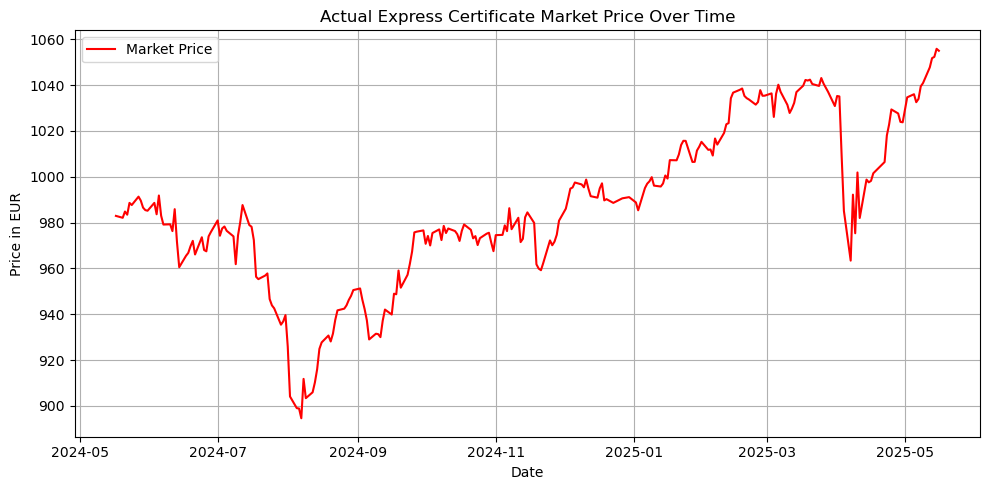

In [7]:

### ========= Plot the real derivative price data =============

import pandas as pd
import matplotlib.pyplot as plt

# Load CSV 
df = pd.read_csv("certificate_price_data.csv", sep=";")

# Clean numeric columns
df["Schluss"] = df["Schluss"].str.replace(".", "", regex=False)  # remove thousand dots
df["Schluss"] = df["Schluss"].str.replace(",", ".", regex=False)  # change decimal comma to dot
df["Schluss"] = df["Schluss"].astype(float)

# Parse and sort dates
df["Datum"] = pd.to_datetime(df["Datum"], format="%d.%m.%Y")
df = df.sort_values("Datum")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df["Datum"], df["Schluss"], label="Market Price", color="red")
plt.title("Actual Express Certificate Market Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price in EUR")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

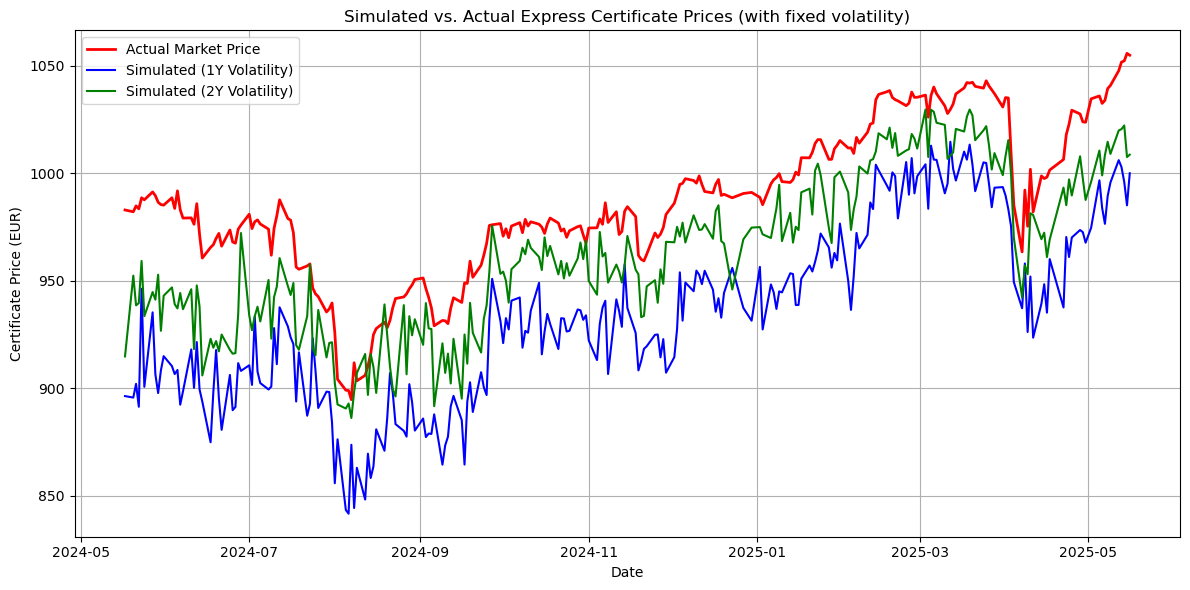

In [8]:
#### ============ Plot all three graphs together =============

# Align all data to same number of dates
# Truncate simulated prices to match the length of actual data

n_days = len(df)
dates = df["Datum"].reset_index(drop=True)

simulated_2y = simulated_prices[:n_days]
simulated_1y = simulated_prices_1y[:n_days]
actual_prices = df["Schluss"].reset_index(drop=True)

# Plot all three graphs together
plt.figure(figsize=(12, 6))

plt.plot(dates, actual_prices, label="Actual Market Price", color="red", linewidth=2)
plt.plot(dates, simulated_1y, label="Simulated (1Y Volatility)", color="blue", linestyle="-")
plt.plot(dates, simulated_2y, label="Simulated (2Y Volatility)", color="green", linestyle="-")


plt.title("Simulated vs. Actual Express Certificate Prices (with fixed volatility)")
plt.xlabel("Date")
plt.ylabel("Certificate Price (EUR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
### ============== Calculate Errors =========

In [10]:

# --- Load market data ---
df_market = pd.read_csv("certificate_price_data.csv", sep=";")
df_market["Schluss"] = df_market["Schluss"].str.replace(".", "", regex=False)
df_market["Schluss"] = df_market["Schluss"].str.replace(",", ".", regex=False)
df_market["Schluss"] = df_market["Schluss"].astype(float)
df_market["Datum"] = pd.to_datetime(df_market["Datum"], format="%d.%m.%Y")
df_market = df_market.sort_values("Datum").reset_index(drop=True)

# --- Align lengths ---
min_length = min(len(simulated_prices_1y), len(simulated_prices), len(df_market))
actual_prices = df_market["Schluss"].iloc[-min_length:].reset_index(drop=True)
sim_1y = simulated_prices_1y[-min_length:]
sim_2y = simulated_prices[-min_length:]

# --- Define a function to compute error metrics ---
def compute_error_metrics(actual, predicted):
    error = predicted - actual
    abs_error = np.abs(error)

    return {
        "Bias": np.mean(error),
        "MAE": np.mean(abs_error),
        "RMSE": np.sqrt(np.mean(error**2)),
        "Q25": np.quantile(abs_error, 0.25),
        "Q50": np.quantile(abs_error, 0.50),
        "Q75": np.quantile(abs_error, 0.75)
    }

# --- Calculate errors ---
metrics_1y = compute_error_metrics(actual_prices, sim_1y)
metrics_2y = compute_error_metrics(actual_prices, sim_2y)

# --- Show results ---
print("Error metrics for 1-year fixed volatility:")
for key, val in metrics_1y.items():
    print(f"{key}: {val:.2f} EUR")

print("\nError metrics for 2-year fixed volatility:")
for key, val in metrics_2y.items():
    print(f"{key}: {val:.2f} EUR")

Error metrics for 1-year fixed volatility:
Bias: -52.00 EUR
MAE: 52.00 EUR
RMSE: 54.12 EUR
Q25: 41.33 EUR
Q50: 50.09 EUR
Q75: 61.22 EUR

Error metrics for 2-year fixed volatility:
Bias: -24.24 EUR
MAE: 24.42 EUR
RMSE: 27.59 EUR
Q25: 15.01 EUR
Q50: 23.35 EUR
Q75: 31.70 EUR
